In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # make figs.
import re
%matplotlib inline

## Read in and clean data

In [4]:
pos_sents = open('pos_sentences.txt', 'r').read().splitlines()
neg_sents = open('neg_sentences.txt', 'r').read().splitlines()
neg_sents[:4]

["Hi [boss/coworker], just wanted to let you know that I finished the project and it's ready for your review. Let me know if you need anything else from me.",
 '',
 "Good morning [boss/coworker], I'm running a few minutes late today due to traffic. I should be in the office by [time].",
 '']

In [5]:
pos_sents = [s for s in pos_sents if s]
neg_sents = [s for s in neg_sents if s]

In [6]:
neg_sents[1]

"Good morning [boss/coworker], I'm running a few minutes late today due to traffic. I should be in the office by [time]."

In [7]:
re.sub('.\[(.*?)\].', '', neg_sents[1]) 

"Good morning I'm running a few minutes late today due to traffic. I should be in the office by"

In [8]:
neg_sents = [re.sub('.\[(.*?)\].', '', s) for s in neg_sents]

In [9]:
train_pos = pos_sents[:int(len(pos_sents) * .8)]
val_pos = pos_sents[int(len(pos_sents) * .8):]

train_neg = neg_sents[:int(len(neg_sents) * .8)]
val_neg = neg_sents[int(len(neg_sents) * .8):]

print('Train pos: ', len(train_pos))
print('Val pos: ', len(val_pos))
print('Train neg: ', len(train_neg))
print('Val neg: ', len(val_neg))


Train pos:  101
Val pos:  26
Train neg:  76
Val neg:  20


In [10]:
# [0] * len(train_pos) + [0] * len(train_neg)
[1] * 2 + [0] * 3

[1, 1, 0, 0, 0]

In [11]:
train_df = pd.DataFrame({
    'target': [1] * len(train_pos) + [0] * len(train_neg),
    'text': train_pos + train_neg,
})

val_df = pd.DataFrame({
    'target': [1] * len(val_pos) + [0] * len(val_neg),
    'text': val_pos + val_neg,
})

train_df.head()

,target,text
0,1,I can't stand working for this jerk. I'm so do...
1,1,I don't know how we're going to get this proje...
2,1,I'm so bored. Can't wait to get out of here an...
3,1,I'm calling in sick tomorrow. I can't handle a...
4,1,I just got offered a job with better pay and b...


## EDA

(Explore data)

In [12]:
# combine all text together
pos_all = ' '.join(train_df[train_df.target == 1].text)
neg_all = ' '.join(train_df[train_df.target == 0].text)



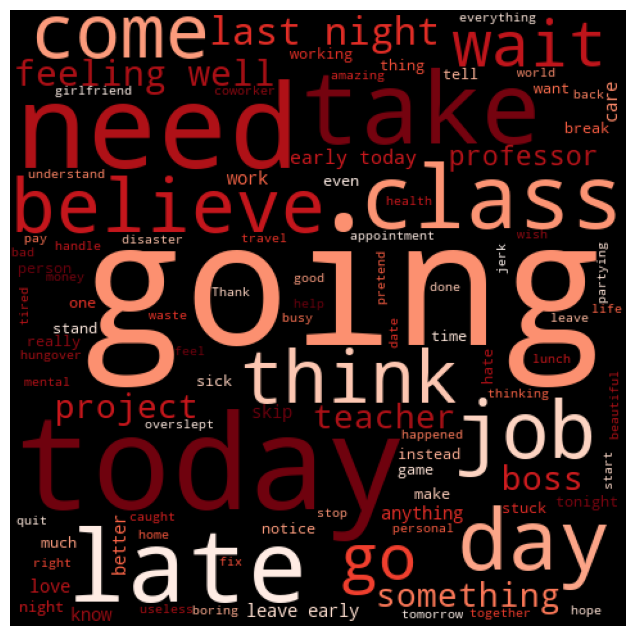

In [13]:
from wordcloud import WordCloud

cloud = WordCloud(max_words=100,width=480, height=480, background_color='black', colormap='Reds')
cloud.generate_from_text(pos_all)

# cloud = WordCloud(max_words=100,width=480, height=480, background_color='black', colormap='Greens')
# cloud.generate_from_text(neg_all)

plt.figure(figsize=(12,8), dpi=100)
plt.imshow(cloud)
plt.axis('off')

# plt.savefig('pos_sent_cloud.png', bbox_inches='tight', pad_inches=0, dpi=1000)
# plt.savefig('neg_sent_cloud.png', bbox_inches='tight', pad_inches=0, dpi=1000)
plt.show()


In [14]:
from collections import Counter

pos_frequencies = Counter(pos_all.split())

for word, freq in pos_frequencies.most_common(10):
    print("{}\t{}".format(word, freq))


I	114
to	80
I'm	59
going	35
a	35
this	25
the	24
can't	22
my	20
have	19


In [15]:
neg_frequencies = Counter(neg_all.split())

for word, freq in neg_frequencies.most_common(10):
    print("{}\t{}".format(word, freq))

to	92
the	71
I	66
you	62
a	41
Hi	36
for	36
wanted	35
I'm	25
be	25


In [16]:
# cleaning more
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wn = WordNetLemmatizer()
sw = stopwords.words('english')

def process_text(x):
    x = x.lower()
    tokens = x.split()
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return " ".join(tokens)

train_df['processed_text'] = train_df.text.apply(process_text)
val_df['processed_text'] = val_df.text.apply(process_text)

In [17]:
pos_frequencies_processed = Counter(process_text(pos_all).split())

for word, freq in pos_frequencies_processed.most_common(10):
    print("{}\t{}".format(word, freq))

going	35
need	14
take	10
late	10
believe	8
think	8
like	7
come	7
get	6
wait	6


In [18]:
neg_frequencies_processed = Counter(process_text(neg_all).split())

for word, freq in neg_frequencies_processed.most_common(10):
    print("{}\t{}".format(word, freq))

hi	36
wanted	35
good	26
professor	20
need	17
let	13
know	13
next	10
anything	9
morning	9


# Naive Bayes Classifier

[Scikit-Learn Description](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable.)

*Bayes' Theorem:*

$P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}$ 


*The naive assumption (conditional independence)*

$P(x_i|y, x_1, ..., x_n) = P(x_i|y)$ 


*Plugging assumtion in*

$P(x_i|y, x_1, ..., x_n) = P(y)\Pi^{n}_{i=1}P(x_i|y)$ 




In [19]:
# first let's get p(y)

pos_prob = train_df['target'].mean()
print('prob pos: ', pos_prob.round(3))
# sum(train_df['target'] == 1) / len(train_df['target'])

neg_prob = (train_df['target'] == 0 ).mean()
print('prob neg: ', neg_prob.round(3))

# check for probabilit y distribution
# pos_prob + neg_prob == 1

prob pos:  0.571
prob neg:  0.429


In [20]:
# now get P(x_i, y)
def prob_wgt(word, target):
  if target == 1:
    count = pos_frequencies[word]
    total = sum(pos_frequencies.values())
  if target == 0:
    count = neg_frequencies[word]
    total = sum(pos_frequencies.values())
  if count == 0:
    count = 1e-5
  return count/total

# def prob_wgt(word, target):
#   if target == 1:
#     count = pos_frequencies_processed[word]
#     total = sum(pos_frequencies_processed.values())
#   if target == 0:
#     count = neg_frequencies_processed[word]
#     total = sum(neg_frequencies_processed.values())
#   if count == 0:
#     count = 1e-5
#   return count/total

In [21]:
prob_wgt('the', 0)


0.05014124293785311

In [22]:
train_df.target.unique()

array([1, 0])

In [23]:
def predict_target(text):
  probs = {}
  for cat in train_df.target.unique():
    nll = 0
    for w in text:
      nll += -np.log(prob_wgt(w, cat))
    probs[cat] = nll

  if probs[0] < probs[1]:
    return 0
  else: 
    return 1
  


In [24]:
predict_target(val_df['processed_text'][0])

0

In [25]:
train_df['nb_prediction'] = train_df.text.apply(predict_target)
val_df['nb_prediction'] = val_df.text.apply(predict_target)


In [26]:
print('training acc: ', (train_df.target == train_df.nb_prediction).mean())
print('val acc:      ', (val_df.target == val_df.nb_prediction).mean())

training acc:  0.6497175141242938
val acc:       0.782608695652174


In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_df.target, train_df.nb_prediction)

array([[45, 31],
       [31, 70]])

In [28]:
confusion_matrix(val_df.target, val_df.nb_prediction)

array([[12,  8],
       [ 2, 24]])

## TF-IDF w/Random Forest

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(stop_words= 'english')
X = vectorizer.fit_transform(train_df.text)
# X = vectorizer.fit_transform(train_df.processed_text)
X

<177x459 sparse matrix of type '<class 'numpy.float64'>'
	with 1293 stored elements in Compressed Sparse Row format>

In [30]:
X_tfidf_val = vectorizer.transform(val_df.text)

In [31]:
rf = RandomForestClassifier(max_depth=10, n_estimators=7, n_jobs=-1)
rf.fit(X, train_df.target)

y_pred_train = rf.predict(X)
print('Train accuracy: ', (train_df.target == y_pred_train).mean().round(3))

y_pred_val = rf.predict(X_tfidf_val)
print('Validation accuracy: ', (val_df.target == y_pred_val).mean().round(3))

Train accuracy:  0.949
Validation accuracy:  0.935


In [32]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

top_word_indicies = []
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    top_word_indicies.append(indices[f])

print("\n")


# Print top features   
for ind in top_word_indicies:
    print(vectorizer.get_feature_names()[ind])

Feature ranking:
1. feature 154 (0.148468)
2. feature 175 (0.070690)
3. feature 437 (0.067953)
4. feature 442 (0.035525)
5. feature 406 (0.034676)
6. feature 247 (0.033538)
7. feature 205 (0.032592)
8. feature 8 (0.029475)
9. feature 300 (0.027096)
10. feature 220 (0.023520)


good
hi
wanted
week
tomorrow
morning
just
afternoon
professor
ll


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
# pos_frequencies['Hi']
# neg_frequencies['Hi']

## Sentence Embedding

In [34]:
from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/opt/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [38]:
train_df.head()

,target,text,processed_text,nb_prediction
0,1,I can't stand working for this jerk. I'm so do...,stand working done,1
1,1,I don't know how we're going to get this proje...,know going get project team,1
2,1,I'm so bored. Can't wait to get out of here an...,wait get go,1
3,1,I'm calling in sick tomorrow. I can't handle a...,calling sick handle another day,1
4,1,I just got offered a job with better pay and b...,got offered job better pay take,1


In [39]:
embeddings_train = minilm.encode(train_df.text, convert_to_tensor=True)

In [40]:
embeddings_val = minilm.encode(val_df.text, convert_to_tensor=True)

In [42]:
embeddings_train.shape

torch.Size([177, 384])

In [56]:
rf_emb = RandomForestClassifier(max_depth=10, n_estimators=7, n_jobs=-1)
rf_emb.fit(embeddings_train.cpu().numpy(), train_df.target)

y_pred_train = rf_emb.predict(embeddings_train)
print('Train accuracy: ', (train_df.target == y_pred_train).mean().round(3))

y_pred_val = rf_emb.predict(embeddings_val)
print('Validation accuracy: ', (val_df.target == y_pred_val).mean().round(3))

Train accuracy:  1.0
Validation accuracy:  0.935


In [120]:
test_y = minilm.encode("Hi I'm running into some issues. I hate you", convert_to_tensor=True)

In [121]:
rf_emb.predict(test_y.reshape(1, -1))
# test_y.reshape(-1, 1)

array([1])

In [119]:
neg_sents[:3]

["Hi just wanted to let you know that I finished the project and it's ready for your review. Let me know if you need anything else from me.",
 "Good morning I'm running a few minutes late today due to traffic. I should be in the office by",
 "Hi I'm having trouble accessing the company database. Are you available to help troubleshoot the issue?"]